# Bleurt with LGBM

This experiment is to use Bleurt scores with top scored LGBM features.

### Feature Engineering

I intend to largely retain the same features as before:

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - Count
  - Ratio
- Quotes Overlap
- Grammar Check
  - Spelling: pyspellchecker

In [1]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("../")

In [2]:
#!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
#!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

In [2]:
from typing import List
import numpy as np
import pandas as pd
import warnings
import logging
import os
import gc
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('@/tmp/.ICE-unix/4917,unix/deepbox'), PosixPath('local/deepbox')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/etc/xdg/xdg-plasma')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/org/freedesktop/DisplayManager/Session1')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/share/gconf/plasma.mandatory.path')}
  warn(msg

In [3]:
from ksum.util import seed_everything, compute_metrics
from ksum.feat import Preprocessor

In [5]:
seed_everything(seed=42)

In [6]:
class CFG:
    #datapath = "/kaggle/input/"
    textmode = "llama2_summ"   # all_prompts, llama2_summ
    datapath = "/home/pedro/git/kaggle_student_summaries/input/"
    model_name="Deberta-v3-base"
    learning_rate=0.000016   #0.000015
    weight_decay=0.03        #0.02
    hidden_dropout_prob=0.007
    attention_probs_dropout_prob=0.007
    num_train_epochs=5
    n_splits=4
    batch_size=12
    random_seed=42
    save_steps=100
    max_length=512

## Dataload

In [7]:
#DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"
DATA_DIR = "../input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")
prompts_train_ref = pd.read_csv("../input/prompt_ref_summaries.csv")

prompts_train = prompts_train.merge(prompts_train_ref, on="prompt_id", how="left")

## Preprocess

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker


In [8]:
preprocessor = Preprocessor(model_name=CFG.model_name, datapath=CFG.datapath)

In [10]:
train = preprocessor.run(prompts_train, summaries_train, mode="train")
test = preprocessor.run(prompts_test, summaries_test, mode="test")

train.head(2)

100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 5450.69it/s]


,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,_llama2_summ,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"The Third Wave experiment, conducted by histor...",660,0.096970,14,4,0.063492,0,0.000000,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","The factory in ""The Jungle"" used various metho...",1076,0.050186,18,22,0.415094,10,0.192308,0


In [ ]:
# Extra
train["word_overlap_ratio"] = train.word_overlap_count / train.summary_length

In [132]:
train.to_parquet("tmp_train_preprocessed.parquet", index=False)

In [ ]:
# Extra: text features aggregated by prompt_id (disabled)
if False:
    featcols = ['summary_length', 'fixed_summary_text', 'splling_err_num',
                'length_ratio', 'word_overlap_count',
                'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count',
                'trigram_overlap_ratio', 'quotes_count']
    
    def make_agg_feat(df):
        aggdf = df.groupby("prompt_id")[featcols].mean()
        aggdf.columns = [f"ap_{c}" for c in aggdf.columns]
        return aggdf.reset_index()
    
    train = train.merge(make_agg_feat(train), on="prompt_id", how="left")
    test = test.merge(make_agg_feat(test), on="prompt_id", how="left")

# Bleurt

In [31]:
sep = "\n"
train["full_prompt"] = (train["prompt_title"] + sep 
                        + train["prompt_question"] + sep 
                        + train["prompt_text"])
test["full_prompt"] = (test["prompt_title"] + sep 
                        + test["prompt_question"] + sep 
                        + test["prompt_text"])

train["short_prompt"] = train["prompt_title"] + sep + train["prompt_question"]
test["short_prompt"] = test["prompt_title"] + sep + test["prompt_question"]

In [36]:
assert train.isnull().sum().sum() == 0
assert test.isnull().sum().sum() == 0

In [70]:
tokenizer = AutoTokenizer.from_pretrained("Elron/bleurt-base-512")
model = AutoModelForSequenceClassification.from_pretrained("Elron/bleurt-base-512")
model.eval()
_ = model.to("cuda")

In [69]:
#del model
#gc.collect()
#torch.cuda.empty_cache()

In [71]:
def eval_bleurt(data, ref_col, cand_col, model, tokenizer, batchsize=200):
    n_splits = len(data)//batchsize 
    allscores = []
    with torch.no_grad():
        for batch in tqdm(np.array_split(data[[ref_col, cand_col]].values, n_splits)):
            inputs = tokenizer(batch[:,0].tolist(), batch[:,1].tolist(), return_tensors='pt', padding=True, truncation=True)
            inputs = {k:v.to("cuda") for k,v in inputs.items()}
            scores = model(**inputs)[0].squeeze().detach().cpu().numpy()
            allscores += scores.tolist()
    return allscores

In [72]:
train["bleurt"] = eval_bleurt(train, "full_prompt", "text", model, tokenizer, batchsize=50)
train["bleurt_fs"] = eval_bleurt(train, "full_prompt", "fixed_summary_text", model, tokenizer, batchsize=50)
train["bleurt_ref"] = eval_bleurt(train, "_llama2_summ", "text", model, tokenizer, batchsize=30)
train["bleurt_ref_fs"] = eval_bleurt(train, "_llama2_summ", "fixed_summary_text", model, tokenizer, batchsize=30)

100%|███████████████████████████████████████████████████████████████████████| 238/238 [00:58<00:00,  4.07it/s]


In [124]:
train.head(2)

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,bleurt,bleurt_fs,fold,bleurt_ref,bleurt_ref_fs,word_overlap_ratio,ap_bleurt,ap_bleurt_fs,ap_bleurt_ref,ap_bleurt_ref_fs
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,...,-1.280535,-1.263821,3.0,-0.961843,-0.898715,0.218750,-1.129359,-1.085604,-0.871894,-0.820891
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,-1.242914,-1.242914,2.0,-1.350477,-1.350477,0.333333,-1.139807,-1.131606,-1.167667,-1.159257


In [123]:
def make_agg_feat(df):
    featcols = [c for c in df.columns if c.startswith("bleurt")]
    aggdf = df.groupby("prompt_id")[featcols].mean()
    aggdf.columns = [f"ap_{c}" for c in aggdf.columns]
    return aggdf.reset_index()
    
train = train.merge(make_agg_feat(train), on="prompt_id", how="left")
test = test.merge(make_agg_feat(test), on="prompt_id", how="left")

# Shortcut

In [4]:
train = pd.read_parquet("tmp_train_preprocessed.parquet")

# Folds

In [7]:
gkf = GroupKFold(n_splits=CFG.n_splits)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

train.head(2)

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,fold,bleurt_ref,bleurt_ref_fs,word_overlap_ratio,ap_bleurt,ap_bleurt_fs,ap_bleurt_ref,ap_bleurt_ref_fs,perplexity,log_perplexity
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,...,3.0,-0.961843,-0.898715,0.218750,-1.129359,-1.085604,-0.871894,-0.820891,34572.480469,10.450813
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,2.0,-1.350477,-1.350477,0.333333,-1.139807,-1.131606,-1.167667,-1.159257,41174.566406,10.625576


## LGBM model

In [8]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text", "full_prompt", "short_prompt", "_llama2_summ",
               ] + targets + [c for c in train.columns if c.startswith("_")]

In [10]:
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'max_depth': 4,  #3
            #'lambda_l1': 0.0,
            #'lambda_l2': 0.011
        }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=2000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                              lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 21
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## CV Score

In [11]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.45926858709262186
wording_rmse : 0.7264473744127359
mcrmse : 0.5928579807526788


Model just text features base and Bleurt
```
content_rmse : 0.4643656763577019
wording_rmse : 0.7178597553344087
mcrmse : 0.5911127158460553
```

In [13]:
featcols = train.drop(columns=drop_columns).columns
feat_importance = pd.DataFrame({'Feature': featcols, 
                                'Importance': model_dict["content"][0].feature_importance()})
feat_importance.sort_values("Importance", ascending=False)

,Feature,Importance
0,summary_length,1037
8,trigram_overlap_ratio,779
6,bigram_overlap_ratio,772
13,bleurt_ref_fs,464
19,perplexity,395
11,bleurt_fs,182
12,bleurt_ref,181
1,splling_err_num,164
3,length_ratio,90
5,bigram_overlap_count,82


```
0	summary_length	421
8	trigram_overlap_ratio	392
6	bigram_overlap_ratio	353
20	bleurt_fs	245
3	length_ratio	159
19	bleurt	113
```

Scores for trained deberta

content_rmse : 0.43503428447443626
wording_rmse : 0.5817162587839311
mcrmse : 0.5083752716291836

For comparison this is the CV for a solution without transformer

{'content_rmse': 0.49269580989800976,
 'wording_rmse': 0.7038373602509493,
 'mcrmse': 0.5982665850744795}

## Predict

In [30]:
drop_columns = [
                #"fold", 
                "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text", "full_prompt", "short_prompt", 
                "input"
               ] + [
                f"content_pred_{i}" for i in range(CFG.n_splits)
                ] + [
                f"wording_pred_{i}" for i in range(CFG.n_splits)
                ]

In [ ]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        X_eval_cv = test.drop(columns=drop_columns)

        pred = model.predict(X_eval_cv)
        preds.append(pred)
    
    pred_dict[target] = preds

In [ ]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

In [ ]:
test

## Create Submission file

In [ ]:
sample_submission

In [ ]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)

## Summary

CV result is like this.

| | content rmse |wording rmse | mcrmse | LB| |
| -- | -- | -- | -- | -- | -- |
|baseline| 0.494 | 0.630 | 0.562 | 0.509 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models)|
| use title and question field | 0.476| 0.619 | 0.548 | 0.508 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields) |
| Debertav3 + LGBM | 0.451 | 0.591 | 0.521 | 0.461 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering) |
| Debertav3 + LGBM with spell autocorrect | 0.448 | 0.581 | 0.514 | 0.459 |nogawanogawa's original code
| Debertav3 + LGBM with spell autocorrect and tuning | 0.442 | 0.566 | 0.504 | 0.453 | this notebook |

The CV values improved slightly, and the LB value is improved.

# Extra: LGBM model without deberta features

In [41]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text",
                "content_pred", "wording_pred"
               ] + targets

model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.048,
            'max_depth': 4,  #3
            'lambda_l1': 0.0,
            'lambda_l2': 0.011
        }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                               lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 10
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [42]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.49610670711293164
wording_rmse : 0.7151874496796461
mcrmse : 0.6056470783962888


Scores with deberta features
```
content_rmse : 0.43503428447443626
wording_rmse : 0.5817162587839311
mcrmse : 0.5083752716291836
```

Scores from kernel without transformer
```
{'content_rmse': 0.49269580989800976, 'wording_rmse': 0.7038373602509493, 'mcrmse': 0.5982665850744795}
```

# Extra: comparing deberta scores with targets

In [45]:
import matplotlib.pyplot as plt

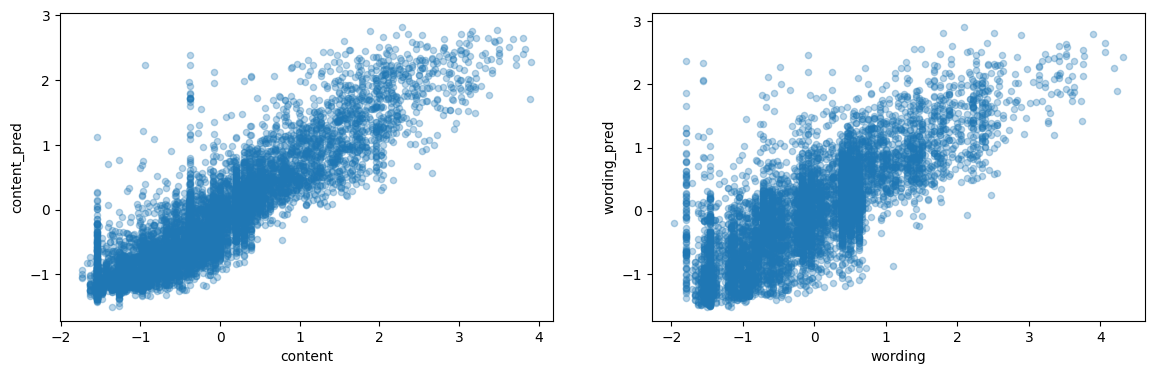

In [46]:
_, ax = plt.subplots(1, 2, figsize=(14,4))
train.plot.scatter(x="content", y="content_pred", alpha=0.3, ax=ax[0])
train.plot.scatter(x="wording", y="wording_pred", alpha=0.3, ax=ax[1]);

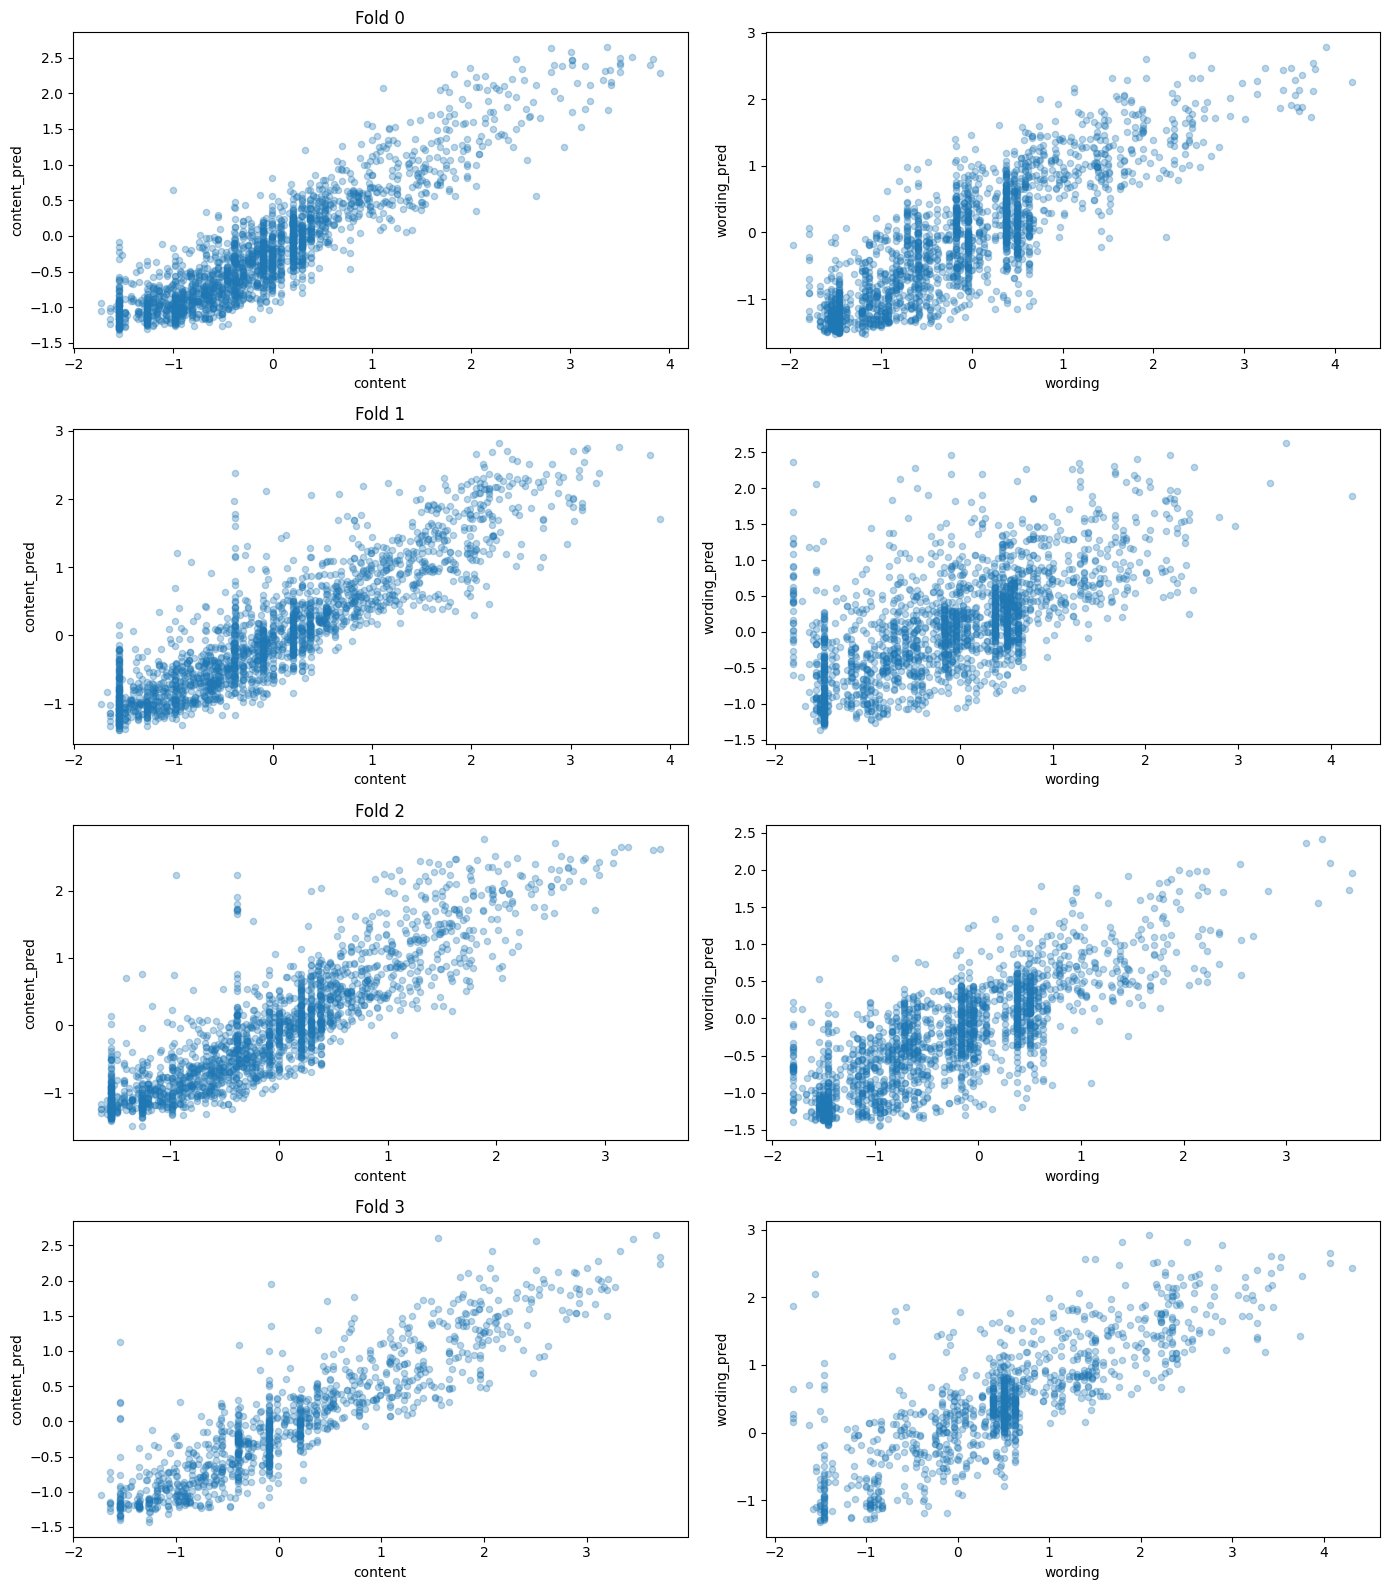

In [53]:
_, ax = plt.subplots(4, 2, figsize=(14,4*4))
for fold in range(4):
    train[train.fold==fold].plot.scatter(x="content", y="content_pred", alpha=0.3, ax=ax[fold][0])
    train[train.fold==fold].plot.scatter(x="wording", y="wording_pred", alpha=0.3, ax=ax[fold][1])
    ax[fold][0].set_title(f"Fold {fold}");
plt.tight_layout();

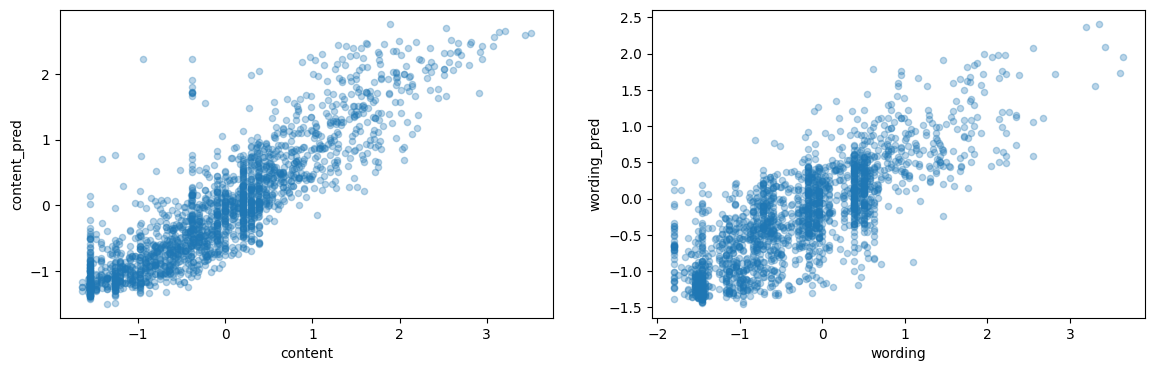

In [49]:
_, ax = plt.subplots(1, 2, figsize=(14,4))
train[train.fold==2].plot.scatter(x="content", y="content_pred", alpha=0.3, ax=ax[0])
train[train.fold==2].plot.scatter(x="wording", y="wording_pred", alpha=0.3, ax=ax[1]);

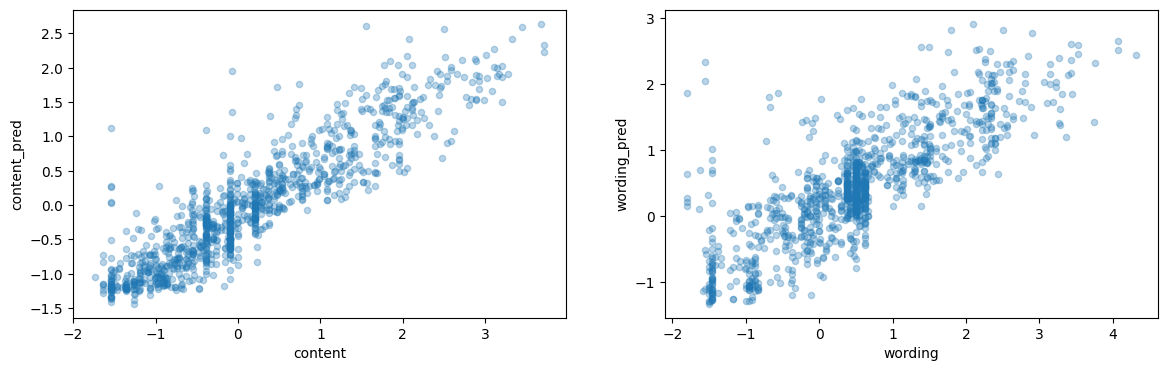

In [50]:
_, ax = plt.subplots(1, 2, figsize=(14,4))
train[train.fold==3].plot.scatter(x="content", y="content_pred", alpha=0.3, ax=ax[0])
train[train.fold==3].plot.scatter(x="wording", y="wording_pred", alpha=0.3, ax=ax[1]);

,student_id,prompt_id,text,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,...,quotes_count,ap_summary_length,ap_splling_err_num,ap_length_ratio,ap_word_overlap_count,ap_bigram_overlap_count,ap_bigram_overlap_ratio,ap_trigram_overlap_count,ap_trigram_overlap_ratio,ap_quotes_count
0,000000ffffff,abc123,Example text 1,3,Example text 1,0,Summarize...,Example Title 1,Heading\nText...,3,...,0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,111111eeeeee,def789,Example text 2,3,Example text 2,0,Summarize...,Example Title 2,Heading\nText...,3,...,0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,222222cccccc,abc123,Example text 3,3,Example text 3,0,Summarize...,Example Title 1,Heading\nText...,3,...,0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,333333dddddd,def789,Example text 4,3,Example text 4,0,Summarize...,Example Title 2,Heading\nText...,3,...,0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sandbox

In [38]:
train.head(2)

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,fold,content_pred,wording_pred
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,...,0.096970,14,4,0.063492,0,0.000000,0,3.0,-0.012359,0.653268
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,0.050186,18,22,0.415094,10,0.192308,0,2.0,-0.641217,0.072646


In [39]:
train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'summary_length', 'fixed_summary_text', 'splling_err_num',
       'prompt_question', 'prompt_title', 'prompt_text', 'prompt_length',
       'length_ratio', 'word_overlap_count', 'bigram_overlap_count',
       'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'fold', 'content_pred',
       'wording_pred'],
      dtype='object')

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/home/pedro/git/kaggle_student_summaries/input/Deberta-v3-base")
tokenizer.sep_token

'[SEP]'

In [29]:
train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'summary_length', 'fixed_summary_text', 'splling_err_num',
       'prompt_question', 'prompt_title', 'prompt_text', '_llama2_summ',
       'prompt_length', 'length_ratio', 'word_overlap_count',
       'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'ap_summary_length',
       'ap_splling_err_num', 'ap_length_ratio', 'ap_word_overlap_count',
       'ap_bigram_overlap_count', 'ap_bigram_overlap_ratio',
       'ap_trigram_overlap_count', 'ap_trigram_overlap_ratio',
       'ap_quotes_count'],
      dtype='object')

# Extra: explore examples

In [109]:
sp = train[train.content.le(0) & train.bleurt_ref_fs.ge(-0.25)].sample()

sp

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,ap_trigram_overlap_ratio,ap_quotes_count,full_prompt,short_prompt,bleurt,bleurt_fs,fold,bleurt_ref,bleurt_ref_fs,word_overlap_ratio
122,04bfd8aac075,814d6b,The Third Wave was developed by Jones who proc...,-0.072284,-1.554745,207,The Third Wave was developed by Jones who proc...,13,Summarize how the Third Wave developed over su...,The Third Wave,...,0.119875,0.148685,The Third Wave\nSummarize how the Third Wave d...,The Third Wave\nSummarize how the Third Wave d...,-0.448355,-0.448355,3.0,-0.186845,-0.186845,0.169082


In [105]:
sp.word_overlap_count, sp.ap_word_overlap_count

(4365    35
 Name: word_overlap_count, dtype: int64,
 4365    12.981583
 Name: ap_word_overlap_count, dtype: float64)

In [101]:
sp.prompt_question.values[0]

'In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.'

In [102]:
sp.prompt_text.values[0]

'Egyptian society was structured like a pyramid. At the top were the gods, such as Ra, Osiris, and Isis. Egyptians believed that the gods controlled the universe. Therefore, it was important to keep them happy. They could make the Nile overflow, cause famine, or even bring death. \r\nThe Egyptians also elevated some human beings to gods. Their leaders, called pharaohs, were believed to be gods in human form. They had absolute power over their subjects. After pharaohs died, huge stone pyramids were built as their tombs. Pharaohs were buried in chambers within the pyramids. \r\nBecause the people of Egypt believed that their pharaohs were gods, they entrusted their rulers with many responsibilities. Protection was at the top of the list. The pharaoh directed the army in case of a foreign threat or an internal conflict. All laws were enacted at the discretion of the pharaoh. Each farmer paid taxes in the form of grains, which were stored in the pharaoh’s warehouses. This grain was used to

In [103]:
sp.text.values[0]

'No single person could manage all these duties without assistance. The pharaoh appointed a chief minister called a vizier as a supervisor. The vizier ensured that taxes were collected. Working with the vizier were scribes who kept government records. These high-level employees had mastered a rare skill in ancient Egypt — they could read and write. Right below the pharaoh in status were powerful nobles and priests. Only nobles could hold government posts; in these positions they profited from tributes paid to the pharaoh. Priests were responsible for pleasing the gods. Nobles enjoyed great status and also grew wealthy from donations to the gods. All Egyptians—from pharaohs to farmers—gave gifts to the gods.Soldiers fought in wars or quelled domestic uprisings. During long periods of peace, soldiers also supervised the peasants, farmers, and slaves who were involved in building such structures as pyramids and palaces. Skilled workers such as physicians and craftsmen/women made up the mi

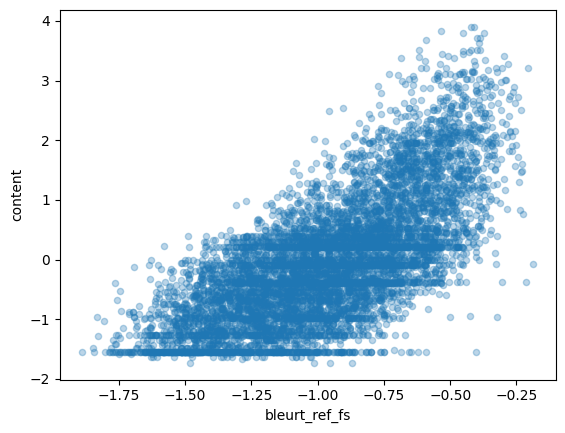

In [106]:
train[].plot.scatter(x="bleurt_ref_fs", y="content", alpha=0.3);

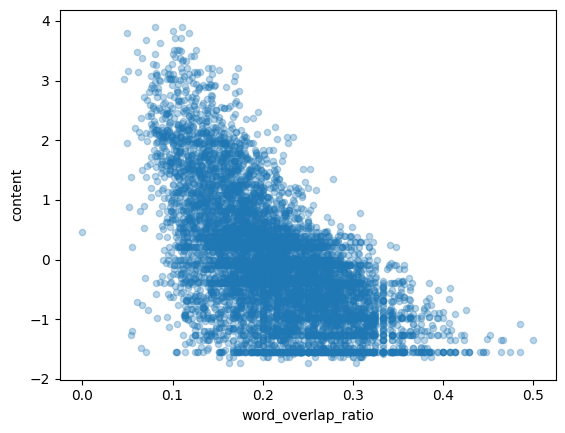

In [114]:

train.plot.scatter(x="word_overlap_ratio", y="content", alpha=0.3);

In [130]:
train.ap_bleurt.unique()

array([-1.1293591 , -1.13980701, -1.19929797, -1.05409713])